In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '4'
os.environ['OPENBLAS_NUM_THREADS'] = '4'
os.environ['NUM_WORKERS'] = '4'
os.environ['MKL_NUM_THREADS'] = '4'
os.environ['NUMEXPR_NUM_THREADS'] = '4'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

import utils

/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
data_path = "/media/HlabShare/Gemechu_work/others"

In [4]:
df = pd.read_csv(f'{data_path}/window_analysis_tw_180_15ms_all.csv')
df = df[~(df.state.isin(['REM', 'rem', 'unknown']))]

In [5]:
df

,species,window_id,animal,expDate,probe,block,condition,state,window_start_s,window_end_s,...,maxeval1_lag2,maxeval2_lag2,glob_str_abs_lag2,glob_str_sig_lag2,alg_conn_lag2,modularity_symabs2,eig_var_lag2,eig_ent_lag2,npz_path,row_index
0,mouse,ZBR092_1128_b1_sb0_w0,ZBR092,1128,1,1,light,wake,0.000,180.000,...,0.296055,0.232787,0.013597,0.012424,0.014194,0.268163,0.007336,2.331338,/media/storage/ZBR092/1128/block1/ZBR092_1128_...,0
1,mouse,ZBR092_1128_b1_sb0_w1,ZBR092,1128,1,1,light,wake,87.990,267.990,...,0.286222,0.182195,0.011748,0.010060,0.015754,0.102300,0.005790,2.316564,/media/storage/ZBR092/1128/block1/ZBR092_1128_...,1
2,mouse,ZBR092_1128_b1_sb0_w2,ZBR092,1128,1,1,light,wake,175.995,355.995,...,0.301189,0.214566,0.013762,0.012521,0.012846,0.197184,0.006548,2.337585,/media/storage/ZBR092/1128/block1/ZBR092_1128_...,2
3,mouse,ZBR092_1128_b1_sb0_w3,ZBR092,1128,1,1,light,wake,264.000,444.000,...,0.324833,0.280410,0.015413,0.014537,0.019399,0.246161,0.008959,2.337443,/media/storage/ZBR092/1128/block1/ZBR092_1128_...,3
4,mouse,ZBR092_1128_b1_sb0_w4,ZBR092,1128,1,1,light,wake,351.990,531.990,...,0.344023,0.289088,0.015767,0.014726,0.012038,0.255235,0.010181,2.286124,/media/storage/ZBR092/1128/block1/ZBR092_1128_...,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25003,rat,XYF06_1217_b10_sb3_w109,XYF06,1217,1,10,light,wake,41991.990,42171.990,...,0.658847,0.176828,0.002761,0.001900,0.010817,0.178102,0.005462,3.853605,/media/storage/XYF06/block10/XYF06_1217_block1...,332
25004,rat,XYF06_1217_b10_sb3_w110,XYF06,1217,1,10,light,wake,42079.995,42259.995,...,0.675110,0.207039,0.002941,0.001966,0.007592,0.205782,0.005961,3.910361,/media/storage/XYF06/block10/XYF06_1217_block1...,333
25005,rat,XYF06_1217_b10_sb3_w111,XYF06,1217,1,10,light,wake,42168.000,42348.000,...,0.587499,0.221000,0.002862,0.001930,0.013215,0.163770,0.004798,4.039214,/media/storage/XYF06/block10/XYF06_1217_block1...,334
25006,rat,XYF06_1217_b10_sb3_w114,XYF06,1217,1,10,light,NREM,42432.000,42612.000,...,0.746164,0.304645,0.004054,0.003950,0.013480,0.177115,0.007773,4.009810,/media/storage/XYF06/block10/XYF06_1217_block1...,335


In [6]:
# Get only rat (species) data
df = df[df.species=='rat']

In [7]:
df.columns

Index(['species', 'window_id', 'animal', 'expDate', 'probe', 'block',
       'condition', 'state', 'window_start_s', 'window_end_s',
       'raster_idx_start', 'raster_idx_end', 'behavior_idx_start',
       'behavior_idx_end', 'behavior_win_len', 'raster_win_len', 'n_neurons',
       'binsz_s', 'rho', 'chi', 'cv', 'fano', 'br', 'maxeval1_lag0',
       'maxeval2_lag0', 'glob_str_abs_lag0', 'glob_str_sig_lag0',
       'alg_conn_lag0', 'modularity_symabs0', 'eig_var_lag0', 'eig_ent_lag0',
       'maxeval1_lag1', 'maxeval2_lag1', 'glob_str_abs_lag1',
       'glob_str_sig_lag1', 'alg_conn_lag1', 'modularity_symabs1',
       'eig_var_lag1', 'eig_ent_lag1', 'maxeval1_lag2', 'maxeval2_lag2',
       'glob_str_abs_lag2', 'glob_str_sig_lag2', 'alg_conn_lag2',
       'modularity_symabs2', 'eig_var_lag2', 'eig_ent_lag2', 'npz_path',
       'row_index'],
      dtype='object')

In [8]:
summary_table = (
    df.groupby(['animal']) ['block']
    .value_counts()
    .unstack(fill_value=0)
    .sort_index()
)
summary_table

block,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17
animal,,,,,,,,,,,,,,,,
XYF03,360,284,302,271,307,290,332,0,0,0,0,0,0,0,0,0
XYF06,338,326,345,355,314,361,355,330,338,325,0,0,0,0,0,0
XYF12,345,327,334,368,323,334,0,365,0,0,308,374,314,0,0,342
XYF13,359,309,0,0,333,347,344,0,0,0,0,0,0,0,0,0
XYF14,294,343,329,340,351,341,0,340,0,0,296,361,302,368,345,295


### Use TimeSeriesMLProcessor to create moving window features
#### On each time step, columns of past time step features are added (as many as window_size)
#### Also statistics (mean, std etc) on the given window are calculated

In [9]:
processor = utils.TimeSeriesMLProcessor(df)
processed_df = processor.create_moving_windows(window_size=5, include_raw_windows=True) #also creates processed_data for processor
processed_df

,animal,block,window_end_index,current_state,transition_type,transition_category,is_transition,previous_state,rho_t0,chi_t0,...,alg_conn_lag2_max_consecutive_change,modularity_symabs2_first_diff,modularity_symabs2_slope,modularity_symabs2_max_consecutive_change,eig_var_lag2_first_diff,eig_var_lag2_slope,eig_var_lag2_max_consecutive_change,eig_ent_lag2_first_diff,eig_ent_lag2_slope,eig_ent_lag2_max_consecutive_change
0,XYF12,1,4,wake,stay_wake,stay_wake,0,wake,0.082226,0.002820,...,0.021803,0.129864,0.035569,0.067729,-0.001021,-0.000125,0.003786,0.018417,0.016381,0.119410
1,XYF12,1,5,wake,stay_wake,stay_wake,0,wake,0.073421,0.002453,...,0.021803,0.144366,0.030426,0.067729,0.000060,0.000384,0.002704,0.236395,0.044515,0.144628
2,XYF12,1,6,wake,stay_wake,stay_wake,0,wake,0.074250,0.002502,...,0.021803,0.019567,0.008754,0.061111,0.000701,0.000067,0.002704,0.156469,0.042235,0.144628
3,XYF12,1,7,wake,stay_wake,stay_wake,0,wake,0.068588,0.002575,...,0.018141,-0.034293,-0.006454,0.061111,0.003186,0.000336,0.004229,-0.030398,0.012332,0.179298
4,XYF12,1,8,wake,stay_wake,stay_wake,0,wake,0.067204,0.002568,...,0.012444,-0.057721,-0.019814,0.061111,0.002778,0.000947,0.004229,-0.099956,-0.033973,0.179298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15075,XYF06,10,320,wake,stay_wake,stay_wake,0,wake,0.084129,0.001436,...,0.020294,-0.028707,-0.021831,0.187442,-0.000137,0.000006,0.002548,-0.138877,-0.035819,0.081398
15076,XYF06,10,321,wake,stay_wake,stay_wake,0,wake,0.090899,0.001388,...,0.011885,-0.054622,-0.000410,0.187442,0.000755,-0.000078,0.002548,-0.099091,-0.027263,0.081398
15077,XYF06,10,322,wake,stay_wake,stay_wake,0,wake,0.085268,0.001368,...,0.011885,0.090808,0.028789,0.078598,-0.002957,-0.000549,0.002218,0.111161,0.020367,0.128854
15078,XYF06,10,323,NREM,wake_to_nrem,wake_to_nrem,1,wake,0.078681,0.001294,...,0.005623,0.077611,0.014089,0.078598,0.002237,0.000381,0.002976,0.080799,0.034721,0.128854


   Training samples: 10827 (transitions: 17786, no-transitions: 288)
   Test samples: 4253 (transitions: 6930, no-transitions: 111)



/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


   Test Balanced Accuracy: 0.3703
   Test AUC: nan



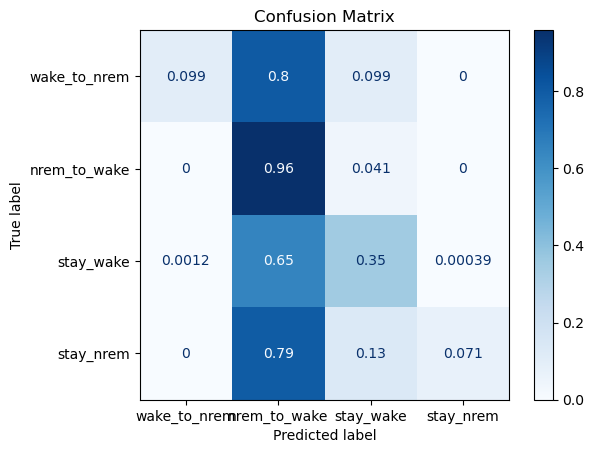

In [13]:
window_size=5
test_size=0.2
random_state=42
animal = None

split = processor.create_balanced_splits(
    split_type='inductive',
    label_type='multiclass',
    test_size=test_size,
    animal=animal,
    random_state=random_state,
    stratify=True
)

X_train, X_test = split['X_train'], split['X_test']
y_train, y_test = split['y_train'], split['y_test']

print(f"   Training samples: {len(X_train)} (transitions: {y_train.sum()}, no-transitions: {(y_train==0).sum()})")
print(f"   Test samples: {len(X_test)} (transitions: {y_test.sum()}, no-transitions: {(y_test==0).sum()})")
print()

# Handle class imbalance - calculate scale_pos_weight
n_negative = (y_train == 0).sum()
n_positive = (y_train == 1).sum()
scale_pos_weight = n_negative / n_positive if n_positive > 0 else 1.0

# Train XGBoost model
# XGBoost parameters for multiclass classification
xgb_params = {
    'objective': 'multi:softmax',
    'eval_metric': 'logloss',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': scale_pos_weight,  # Handle class imbalance
    'random_state': random_state,
    'nthread':5
}

# Create and train model
model = xgb.XGBClassifier(**xgb_params)

# Train with early stopping
model.fit(
    X_train, y_train,
    verbose=False
)


# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = balanced_accuracy_score(y_test, y_pred)
try:
    auc_score = roc_auc_score(y_test, y_pred_proba)
except ValueError:
    auc_score = np.nan  # Handle case where only one class in test set

print(f"   Test Balanced Accuracy: {accuracy:.4f}")
print(f"   Test AUC: {auc_score:.4f}")
print()


label_dict = {0:'wake_to_nrem', 1:'nrem_to_wake', 2:'stay_wake', 3:'stay_nrem'}
labels = sorted(label_dict.keys())
label_names = [label_dict[l] for l in labels]
# 'multiclass_raw': multiclass_labels,  # wake_to_nrem, nrem_to_wake, stay_wake, stay_nrem
# 'multiclass_encoded': multiclass_encoded,  # 0, 1, 2, 3

# Compute confusion matrix
#labels =  ['No Transition', 'Transition']
cm = confusion_matrix(y_test, y_pred, normalize='true', labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()



### Feature importance


Top 20 Features by Importance:
                      Feature  Importance
100          maxeval1_lag1_t3    0.136365
171        maxeval1_lag1_mean    0.109200
129          maxeval1_lag1_t4    0.055598
242  maxeval1_lag1_first_diff    0.017109
179        alg_conn_lag1_mean    0.014116
209             cv_first_diff    0.013698
157        maxeval2_lag0_mean    0.013135
98            eig_var_lag0_t3    0.013057
203            rho_first_diff    0.012446
185         eig_ent_lag1_mean    0.010953
183         eig_var_lag1_mean    0.010792
106           eig_var_lag1_t3    0.010697
167         eig_var_lag0_mean    0.010288
118                     cv_t4    0.010164
116                    rho_t4    0.009603
87                     rho_t3    0.009405
137          maxeval1_lag2_t4    0.008719
89                      cv_t3    0.008166
145                  rho_mean    0.007533
212           fano_first_diff    0.006948


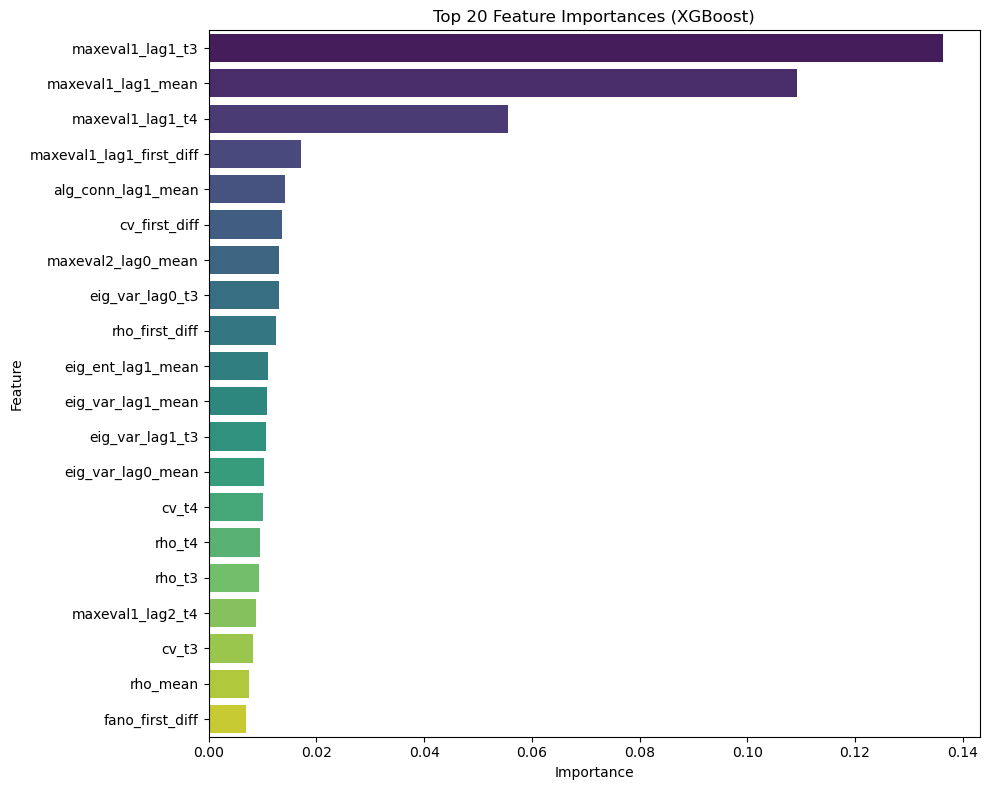

In [14]:
# Build dataframe of feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

# Show top features
print("\nTop 20 Features by Importance:")
print(feature_importance.head(20))

# Plot top 20
plt.figure(figsize=(10, 8))
sns.barplot(
    data=feature_importance.head(20),
    x='Importance',
    y='Feature',
    palette='viridis'
)
plt.title("Top 20 Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Hyperparameter optimization

### Simple random HP optimization

In [11]:
# make validation set from training set

rs = 42

train_df = processed_df.iloc[split['X_train'].index]

train_processor = utils.TimeSeriesMLProcessor(pd.DataFrame())

train_processor.processed_data = train_df

split = train_processor.create_balanced_splits(
    split_type='inductive',
    label_type='multiclass',
    test_size=test_size,
    animal=animal,
    random_state=random_state,
    stratify=True
)

X_train, X_valid = split['X_train'], split['X_test']
y_train, y_valid = split['y_train'], split['y_test']


from sklearn.model_selection import ParameterSampler

# Define search space (same as your param_grid)
param_grid = {
    'n_estimators': [20, 50, 100, 120, 150, 200, 250],
    'max_depth': [1, 2, 3, 4, 5, 6],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'scale_pos_weight': [1, 2, 3, 4, 5, 6, 7],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# Generate random samples of hyperparameters
n_iter = 50
param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=rs))

best_score = -np.inf
best_params = None
best_model = None

for params in param_list:
    model = xgb.XGBClassifier(
        objective = 'multi:softmax',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=rs,
        nthread = 5,
        verbosity=0,
        **params
    )
    
    model.fit(X_train, y_train)
    
    # Evaluate on validation set
    y_pred = model.predict(X_valid)
    score = balanced_accuracy_score(y_valid, y_pred)
    
    if score > best_score:
        best_score = score
        best_params = params
        best_model = model

print("\nBest parameters:", best_params)
print("Best balanced accuracy on validation set: %.4f" % best_score)



/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/hlabhome/g.tolossa/.conda/envs/mlp_clas


Best parameters: {'subsample': 0.9, 'scale_pos_weight': 6, 'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best balanced accuracy on validation set: 0.6956


### Testing with simple random search hyperparameters

   Training samples: 10827 (no transitions: 6957,transitions: 3870)
   Test samples: 4253 (no transitions: 2676,transitions: 1577)



/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


   Test Balanced Accuracy: 0.3681
   Test AUC: nan



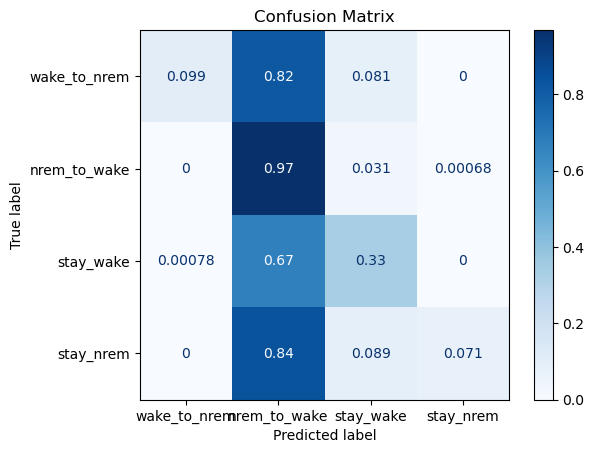

In [12]:
window_size=5
test_size=0.2
random_state=42
animal = None

split = processor.create_balanced_splits(
    split_type='inductive',
    label_type='multiclass',
    test_size=test_size,
    animal=animal,
    random_state=random_state,
    stratify=True
)

X_train, X_test = split['X_train'], split['X_test']
y_train, y_test = split['y_train'], split['y_test']

print(f"   Training samples: {len(X_train)} (no transitions: {((y_train==2)|(y_train==3)).sum()},transitions: {((y_train==0)|(y_train==1)).sum()})")
print(f"   Test samples: {len(X_test)} (no transitions: {((y_test==2)|(y_test==3)).sum()},transitions: {((y_test==0)|(y_test==1)).sum()})")
print()

# Handle class imbalance - calculate scale_pos_weight
n_negative = (y_train == 0).sum()
n_positive = (y_train == 1).sum()
scale_pos_weight = n_negative / n_positive if n_positive > 0 else 1.0

# Train XGBoost model
# XGBoost parameters for multiclass classification
xgb_params = {
    'objective': 'multi:softmax',
    'eval_metric': 'logloss',
    'random_state': random_state,
    'nthread': 5,
    **best_params
}

# Create and train model
model = xgb.XGBClassifier(**xgb_params)

# Train with early stopping
model.fit(
    X_train, y_train,
    verbose=False
)


# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = balanced_accuracy_score(y_test, y_pred)
try:
    auc_score = roc_auc_score(y_test, y_pred_proba)
except ValueError:
    auc_score = np.nan  # Handle case where only one class in test set

print(f"   Test Balanced Accuracy: {accuracy:.4f}")
print(f"   Test AUC: {auc_score:.4f}")
print()


label_dict = {0:'wake_to_nrem', 1:'nrem_to_wake', 2:'stay_wake', 3:'stay_nrem'}
labels = sorted(label_dict.keys())
label_names = [label_dict[l] for l in labels]
# 'multiclass_raw': multiclass_labels,  # wake_to_nrem, nrem_to_wake, stay_wake, stay_nrem
# 'multiclass_encoded': multiclass_encoded,  # 0, 1, 2, 3

# Compute confusion matrix
#labels =  ['No Transition', 'Transition']
cm = confusion_matrix(y_test, y_pred, normalize='true', labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


### sklearn randomsearch hyperparamter optimization

In [15]:
# Create scorer
scorer = make_scorer(balanced_accuracy_score)

# Create base model
base_model = xgb.XGBClassifier(
    objective = 'multi:softmax',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=rs,
    nthread = 5,
    verbosity=0
)

rs = 42
split = train_processor.create_balanced_splits(
    split_type='inductive',
    label_type='multiclass',
    test_size=test_size,
    animal=animal,
    random_state=random_state,
    stratify=True
)

X_train, X_valid = split['X_train'], split['X_test']
y_train, y_valid = split['y_train'], split['y_test']

# Create a predefined split to use your exact train/validation split
# Mark training samples as -1 and validation samples as 0
X_combined = np.vstack([X_train, X_valid])
y_combined = np.hstack([y_train, y_valid])
test_fold = np.hstack([np.full(len(X_train), -1), np.zeros(len(X_valid))])

ps = PredefinedSplit(test_fold)
n_iter = 100
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=n_iter,
    scoring=scorer,
    cv=ps,  # Use your predefined split
    random_state=rs,
)

random_search.fit(X_combined, y_combined)

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None...
                                           subsample=None, tree_method=None,
                                           use_label_encoder=False, ...),
                   n_iter=100,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9,
                                                             1.0],
                                        'learning_rate': [0.01, 0.03, 0.05,
                                                          0.1],
                                        'max_depth': [1, 2, 3, 4, 5, 6],
                                        'n_estimators': [20, 50, 100, 120, 150,
                                                         200, 250],
                                        'scale_pos_weight': [1, 2, 3, 4, 5, 6,
                                                             7],
                                        'subsample': [0.7, 0.8, 0.9, 1.0]},
                   random_state=42,
                   scoring=make_scorer(balanced_accuracy_score))

### Testing with sklearn randomsearch hyperparameters

/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


   Test Balanced Accuracy: 0.3676
   Test AUC: nan



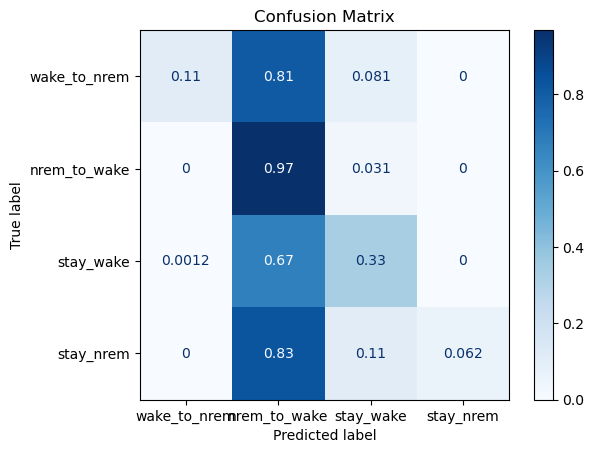

In [16]:
window_size=5
test_size=0.2
random_state=42
animal = None

split = processor.create_balanced_splits(
    split_type='inductive',
    label_type='multiclass',
    test_size=test_size,
    animal=animal,
    random_state=random_state,
    stratify=True
)

X_train, X_test = split['X_train'], split['X_test']
y_train, y_test = split['y_train'], split['y_test']


# Handle class imbalance - calculate scale_pos_weight
n_negative = (y_train == 0).sum()
n_positive = (y_train == 1).sum()
scale_pos_weight = n_negative / n_positive if n_positive > 0 else 1.0

# Train XGBoost model
xgb_params = {
    'objective': 'multi:softmax',
    'eval_metric': 'logloss',
    'random_state': random_state,
    **best_params
}
xgb_params = random_search.best_params_
# Create and train model
model = xgb.XGBClassifier(**xgb_params)

# Train with early stopping
model.fit(
    X_train, y_train,
    verbose=False
)


# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = balanced_accuracy_score(y_test, y_pred)
try:
    auc_score = roc_auc_score(y_test, y_pred_proba)
except ValueError:
    auc_score = np.nan  # Handle case where only one class in test set

print(f"   Test Balanced Accuracy: {accuracy:.4f}")
print(f"   Test AUC: {auc_score:.4f}")
print()


label_dict = {0:'wake_to_nrem', 1:'nrem_to_wake', 2:'stay_wake', 3:'stay_nrem'}
labels = sorted(label_dict.keys())
label_names = [label_dict[l] for l in labels]
# 'multiclass_raw': multiclass_labels,  # wake_to_nrem, nrem_to_wake, stay_wake, stay_nrem
# 'multiclass_encoded': multiclass_encoded,  # 0, 1, 2, 3

# Compute confusion matrix
#labels =  ['No Transition', 'Transition']
cm = confusion_matrix(y_test, y_pred, normalize='true', labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


### Feature importance after hp optimization


Top 20 Features by Importance:
                      Feature  Importance
100          maxeval1_lag1_t3    0.142373
171        maxeval1_lag1_mean    0.050291
129          maxeval1_lag1_t4    0.040006
183         eig_var_lag1_mean    0.025847
179        alg_conn_lag1_mean    0.014993
242  maxeval1_lag1_first_diff    0.014110
209             cv_first_diff    0.013103
118                     cv_t4    0.012789
157        maxeval2_lag0_mean    0.011885
167         eig_var_lag0_mean    0.011269
145                  rho_mean    0.010213
98            eig_var_lag0_t3    0.009908
87                     rho_t3    0.009908
116                    rho_t4    0.009389
203            rho_first_diff    0.009312
195        alg_conn_lag2_mean    0.009242
106           eig_var_lag1_t3    0.008851
199         eig_var_lag2_mean    0.007578
89                      cv_t3    0.007392
103      glob_str_sig_lag1_t3    0.006873


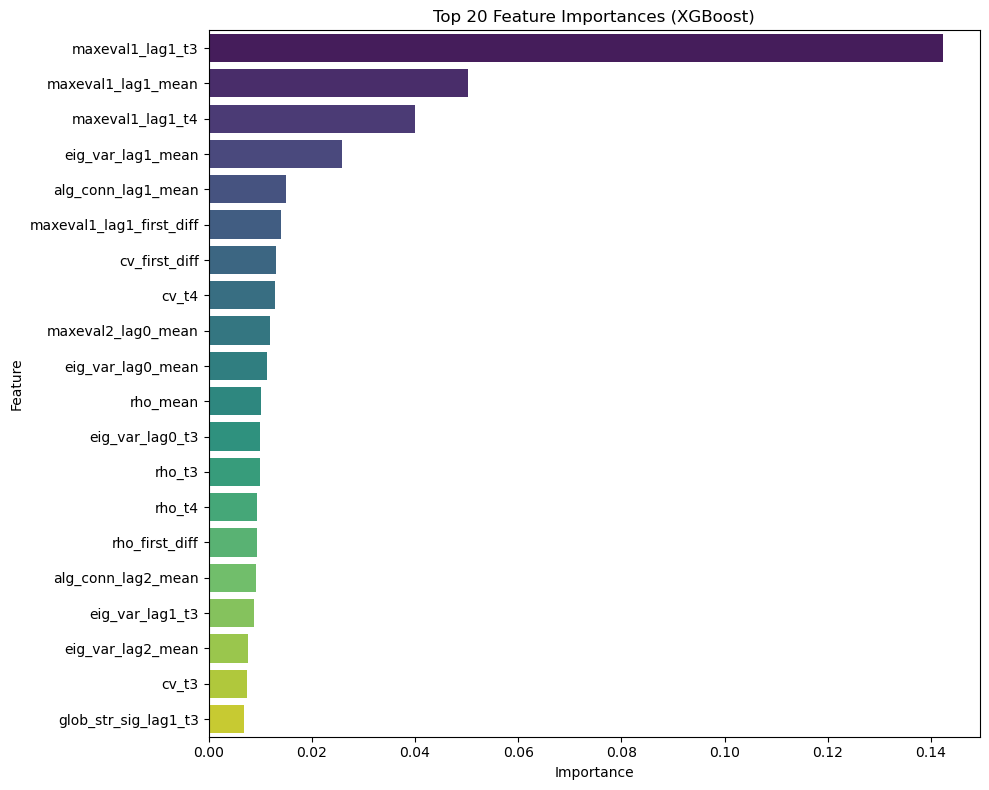

In [17]:
# Build dataframe of feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

# Show top features
print("\nTop 20 Features by Importance:")
print(feature_importance.head(20))

# Plot top 20
plt.figure(figsize=(10, 8))
sns.barplot(
    data=feature_importance.head(20),
    x='Importance',
    y='Feature',
    palette='viridis'
)
plt.title("Top 20 Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
